In [1]:
%run import_libs.py

### get data

In [2]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [3]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [4]:
df_train.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.868580,0.581678,0.0,0,0.0,NaN,NaN,0,0.708906,...,1,0,5,0,2,0,0,-1,6,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.861109,0.510142,0.0,0,0.0,NaN,0.060646,0,0.239459,...,1,0,0,0,2,3,0,-1,6,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.797670,0.381123,0.0,0,0.0,NaN,NaN,0,0.222406,...,1,0,0,0,2,3,2,-1,6,0


In [5]:
df_test.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,0.535311,0.958618,0,0.0,0.103745,0.006272,0,0.004483,...,2,0,0,0,1,1,0,3,-1,6
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.794469,0.385655,0.000000,0,0.0,NaN,NaN,0,0.076225,...,2,1,0,4,0,2,3,0,-1,6
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.673112,0.381666,0.000000,0,0.0,NaN,0.085228,0,0.041670,...,2,0,0,4,0,1,0,3,1,4


In [4]:
cat_features = [f"{f}_last" for f in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
cat_features

['B_30_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_63_last',
 'D_64_last',
 'D_66_last',
 'D_68_last']

In [5]:
payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in list(df_train):
    if feat in cat_features:
        continue
    
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [6]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

604

In [7]:
num_features = payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats
len(num_features)

604

### LightGBM (all features)

In [ ]:
feature_cols = num_features + cat_features
X = df_train[feature_cols]
y = df_train['target'].values
groups = df_train['customer_ID'].values

params = dict(
    learning_rate   = 0.05,
    subsample       = 0.9,
    subsample_freq  = 1,          # без этой штуки subsample у lgbm не заработает
    colsample_bytree= 0.8,
    num_leaves      = 64,
    max_depth       = 5,
    n_estimators    = 350,
    objective       = 'binary',
    verbosity       = -1,
    random_state    = 42
)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = [] # train_cv scores
y_pred_list = [] # test scores to submit

for fold, (tr_idx, va_idx) in enumerate(sgkf.split(
        X=df_train[['customer_ID', 'target']],
        y=y,
        groups=groups)):
    
    print(f"Fold {fold}")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    
    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric=lgb_amex_metric,
        categorical_feature=cat_features
    )
    
    y_pred = model.predict_proba(X_va)[:, 1]
    score = get_amex_metric_calculated(y_va, y_pred)
    print(f"  Amex = {score:.5f}")
    fold_scores.append(score)

    # predict test at each fold
    y_pred_list.append(model.predict_proba(df_test[feature_cols], raw_score=True))

print(f"\nMean CV Amex: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")

Fold 0
  Amex = 0.78540
Fold 1
  Amex = 0.78871
Fold 2
  Amex = 0.78870
Fold 3
  Amex = 0.78663
Fold 4
  Amex = 0.78985

Mean CV Amex: 0.78786 ± 0.00161


In [31]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': df_test.customer_ID,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_lgbm_all_features.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.112161
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.483655
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.919210
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.519460
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.987848
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.867522
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.531089
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.238545
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.620260


### Random Forest (all features)

### Backward selection (lgbm)

In [10]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=10
)


=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 400
Fold 0
 Amex = 0.78621
Fold 1
 Amex = 0.79092
Fold 2
 Amex = 0.78966
Fold 3
 Amex = 0.78750
Fold 4
 Amex = 0.78977
Mean CV Amex = 0.78881  CI95 = [0.78644, 0.79118]

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 400
Fold 0
 Amex = 0.78640
Fold 1
 Amex = 0.79214
Fold 2
 Amex = 0.79063
Fold 3
 Amex = 0.78861
Fold 4
 Amex = 0.78964
Mean CV Amex = 0.78948  CI95 = [0.78680, 0.79217]


[I 2025-05-07 01:01:15,170] A new study created in memory with name: no-name-5c49cd09-571d-4aa7-b474-2a3545d20051


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 01:22:17,839] Trial 3 finished with value: -0.7746367308230045 and parameters: {'max_depth': 2, 'n_estimators': 359}. Best is trial 3 with value: -0.7746367308230045.
[I 2025-05-07 01:23:36,618] Trial 7 finished with value: -0.7845922081827592 and parameters: {'max_depth': 3, 'n_estimators': 469}. Best is trial 7 with value: -0.7845922081827592.
[I 2025-05-07 01:27:21,111] Trial 9 finished with value: -0.7832933219860643 and parameters: {'max_depth': 3, 'n_estimators': 405}. Best is trial 7 with value: -0.7845922081827592.
[I 2025-05-07 01:29:45,032] Trial 1 finished with value: -0.7871525306122276 and parameters: {'max_depth': 4, 'n_estimators': 432}. Best is trial 1 with value: -0.7871525306122276.
[I 2025-05-07 01:30:50,151] Trial 0 finished with value: -0.7852528004648184 and parameters: {'max_depth': 4, 'n_estimators': 321}. Best is trial 1 with value: -0.7871525306122276.
[I 2025-05-07 01:32:50,533] Trial 11 finished with value: -0.7842214524071225 and parameters: {

[I 2025-05-07 02:13:18,597] A new study created in memory with name: no-name-00044dc0-80f6-4717-9b59-66cf7b2a0910


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 02:31:02,211] Trial 8 finished with value: -0.7691290095620011 and parameters: {'max_depth': 2, 'n_estimators': 256}. Best is trial 8 with value: -0.7691290095620011.
[I 2025-05-07 02:31:25,470] Trial 11 finished with value: -0.7708403609262844 and parameters: {'max_depth': 2, 'n_estimators': 284}. Best is trial 11 with value: -0.7708403609262844.
[I 2025-05-07 02:33:05,206] Trial 6 finished with value: -0.778075700184494 and parameters: {'max_depth': 2, 'n_estimators': 444}. Best is trial 6 with value: -0.778075700184494.
[I 2025-05-07 02:35:43,972] Trial 7 finished with value: -0.7882971661769034 and parameters: {'max_depth': 5, 'n_estimators': 351}. Best is trial 7 with value: -0.7882971661769034.
[I 2025-05-07 02:36:26,941] Trial 4 finished with value: -0.7822299978657338 and parameters: {'max_depth': 3, 'n_estimators': 378}. Best is trial 7 with value: -0.7882971661769034.
[I 2025-05-07 02:36:34,292] Trial 9 finished with value: -0.7836884111754082 and parameters: {'

[I 2025-05-07 03:08:00,901] A new study created in memory with name: no-name-d372f0c9-0006-4f77-b483-79ef0b250ff9


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 03:22:51,536] Trial 7 finished with value: -0.7784279272425347 and parameters: {'max_depth': 2, 'n_estimators': 477}. Best is trial 7 with value: -0.7784279272425347.
[I 2025-05-07 03:25:25,035] Trial 8 finished with value: -0.7777164700874037 and parameters: {'max_depth': 3, 'n_estimators': 256}. Best is trial 7 with value: -0.7784279272425347.
[I 2025-05-07 03:27:46,159] Trial 1 finished with value: -0.7880887612877192 and parameters: {'max_depth': 8, 'n_estimators': 278}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:32:45,795] Trial 12 finished with value: -0.7840229985385401 and parameters: {'max_depth': 3, 'n_estimators': 454}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:33:14,903] Trial 9 finished with value: -0.7861418272137496 and parameters: {'max_depth': 6, 'n_estimators': 243}. Best is trial 1 with value: -0.7880887612877192.
[I 2025-05-07 03:33:16,175] Trial 0 finished with value: -0.7870889862047965 and parameters: {

[I 2025-05-07 03:54:46,458] A new study created in memory with name: no-name-6f10310b-6606-4709-9566-ea83b78c9843


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 04:10:11,483] Trial 1 finished with value: -0.7841747580209468 and parameters: {'max_depth': 4, 'n_estimators': 292}. Best is trial 1 with value: -0.7841747580209468.
[I 2025-05-07 04:11:48,078] Trial 7 finished with value: -0.7873335004414415 and parameters: {'max_depth': 8, 'n_estimators': 291}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:12:24,789] Trial 0 finished with value: -0.7823159471305786 and parameters: {'max_depth': 3, 'n_estimators': 390}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:14:10,278] Trial 3 finished with value: -0.7851531987256832 and parameters: {'max_depth': 4, 'n_estimators': 326}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:14:42,627] Trial 10 finished with value: -0.7839402535786013 and parameters: {'max_depth': 5, 'n_estimators': 228}. Best is trial 7 with value: -0.7873335004414415.
[I 2025-05-07 04:16:03,741] Trial 8 finished with value: -0.7871041661742856 and parameters: {

[I 2025-05-07 04:36:56,150] A new study created in memory with name: no-name-3d2c78d4-8308-43fc-a873-06c2124efcbe


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 04:50:52,899] Trial 7 finished with value: -0.775810390264571 and parameters: {'max_depth': 2, 'n_estimators': 396}. Best is trial 7 with value: -0.775810390264571.
[I 2025-05-07 04:52:35,587] Trial 5 finished with value: -0.7753251784285716 and parameters: {'max_depth': 3, 'n_estimators': 220}. Best is trial 7 with value: -0.775810390264571.
[I 2025-05-07 04:53:31,665] Trial 4 finished with value: -0.7792766552352642 and parameters: {'max_depth': 3, 'n_estimators': 305}. Best is trial 4 with value: -0.7792766552352642.
[I 2025-05-07 04:53:50,548] Trial 11 finished with value: -0.780646334872506 and parameters: {'max_depth': 4, 'n_estimators': 230}. Best is trial 11 with value: -0.780646334872506.
[I 2025-05-07 04:54:49,801] Trial 1 finished with value: -0.7877338159058995 and parameters: {'max_depth': 8, 'n_estimators': 317}. Best is trial 1 with value: -0.7877338159058995.
[I 2025-05-07 04:55:11,898] Trial 0 finished with value: -0.7857408688576595 and parameters: {'max

[I 2025-05-07 05:13:43,096] A new study created in memory with name: no-name-6eb0c05b-d212-408a-b335-95d199a41dce


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 05:27:14,653] Trial 1 finished with value: -0.7799957862273084 and parameters: {'max_depth': 4, 'n_estimators': 218}. Best is trial 1 with value: -0.7799957862273084.
[I 2025-05-07 05:28:07,228] Trial 0 finished with value: -0.7656890983957221 and parameters: {'max_depth': 2, 'n_estimators': 217}. Best is trial 1 with value: -0.7799957862273084.
[I 2025-05-07 05:29:44,669] Trial 7 finished with value: -0.7872136157054855 and parameters: {'max_depth': 6, 'n_estimators': 402}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:29:49,669] Trial 4 finished with value: -0.7759146499327335 and parameters: {'max_depth': 2, 'n_estimators': 407}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:30:05,141] Trial 3 finished with value: -0.7796625373800626 and parameters: {'max_depth': 3, 'n_estimators': 324}. Best is trial 7 with value: -0.7872136157054855.
[I 2025-05-07 05:31:07,781] Trial 10 finished with value: -0.7820671811808123 and parameters: {

[I 2025-05-07 05:46:32,069] A new study created in memory with name: no-name-3c0f88e8-59da-4c99-bb0b-51a890c6e53c


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 06:01:37,072] Trial 9 finished with value: -0.776749010665483 and parameters: {'max_depth': 2, 'n_estimators': 475}. Best is trial 9 with value: -0.776749010665483.
[I 2025-05-07 06:02:04,750] Trial 5 finished with value: -0.7796042361753912 and parameters: {'max_depth': 4, 'n_estimators': 222}. Best is trial 5 with value: -0.7796042361753912.
[I 2025-05-07 06:03:59,778] Trial 11 finished with value: -0.7826639428182893 and parameters: {'max_depth': 5, 'n_estimators': 246}. Best is trial 11 with value: -0.7826639428182893.
[I 2025-05-07 06:04:03,451] Trial 7 finished with value: -0.7864094026300464 and parameters: {'max_depth': 7, 'n_estimators': 495}. Best is trial 7 with value: -0.7864094026300464.
[I 2025-05-07 06:04:23,498] Trial 1 finished with value: -0.7859548749240947 and parameters: {'max_depth': 8, 'n_estimators': 354}. Best is trial 7 with value: -0.7864094026300464.
[I 2025-05-07 06:04:24,201] Trial 4 finished with value: -0.7832707704491083 and parameters: {'

[I 2025-05-07 06:20:37,719] A new study created in memory with name: no-name-4dda8fa6-931c-412c-a4be-ffa1d84110a7


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 06:34:00,894] Trial 7 finished with value: -0.7809891420533827 and parameters: {'max_depth': 5, 'n_estimators': 294}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:34:57,038] Trial 11 finished with value: -0.7713999655098346 and parameters: {'max_depth': 2, 'n_estimators': 329}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:34:59,292] Trial 9 finished with value: -0.7684968444598994 and parameters: {'max_depth': 2, 'n_estimators': 268}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:14,964] Trial 2 finished with value: -0.7718823628093321 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:17,345] Trial 3 finished with value: -0.7739428776200193 and parameters: {'max_depth': 3, 'n_estimators': 236}. Best is trial 7 with value: -0.7809891420533827.
[I 2025-05-07 06:35:24,383] Trial 1 finished with value: -0.7820978550012463 and parameters: {

[I 2025-05-07 06:51:13,530] A new study created in memory with name: no-name-1e0f0e4a-16ff-4fa8-828b-82617ad72d8d


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 07:04:38,915] Trial 7 finished with value: -0.7684622495455049 and parameters: {'max_depth': 2, 'n_estimators': 299}. Best is trial 7 with value: -0.7684622495455049.
[I 2025-05-07 07:05:30,453] Trial 10 finished with value: -0.7714757251336424 and parameters: {'max_depth': 2, 'n_estimators': 380}. Best is trial 10 with value: -0.7714757251336424.
[I 2025-05-07 07:06:10,305] Trial 4 finished with value: -0.7735933179650564 and parameters: {'max_depth': 2, 'n_estimators': 470}. Best is trial 4 with value: -0.7735933179650564.
[I 2025-05-07 07:06:59,748] Trial 1 finished with value: -0.7788521071627303 and parameters: {'max_depth': 5, 'n_estimators': 284}. Best is trial 1 with value: -0.7788521071627303.
[I 2025-05-07 07:07:12,712] Trial 8 finished with value: -0.7788020723544212 and parameters: {'max_depth': 5, 'n_estimators': 283}. Best is trial 1 with value: -0.7788521071627303.
[I 2025-05-07 07:07:13,568] Trial 5 finished with value: -0.7774360180697246 and parameters: 

[I 2025-05-07 07:22:46,521] A new study created in memory with name: no-name-4e286071-50a0-499f-96b3-cca7f10bc319


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 07:36:35,180] Trial 6 finished with value: -0.7662278598142664 and parameters: {'max_depth': 2, 'n_estimators': 288}. Best is trial 6 with value: -0.7662278598142664.
[I 2025-05-07 07:37:57,690] Trial 0 finished with value: -0.7769075242710949 and parameters: {'max_depth': 5, 'n_estimators': 384}. Best is trial 0 with value: -0.7769075242710949.
[I 2025-05-07 07:38:00,569] Trial 5 finished with value: -0.7771349477244704 and parameters: {'max_depth': 7, 'n_estimators': 319}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:35,325] Trial 9 finished with value: -0.7741745839447531 and parameters: {'max_depth': 3, 'n_estimators': 407}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:50,093] Trial 10 finished with value: -0.7768423023061626 and parameters: {'max_depth': 7, 'n_estimators': 305}. Best is trial 5 with value: -0.7771349477244704.
[I 2025-05-07 07:38:55,972] Trial 4 finished with value: -0.7768955331345259 and parameters: {

[I 2025-05-07 07:53:19,690] A new study created in memory with name: no-name-55dbb605-65c0-4433-beb6-089dde18edb5


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 08:07:06,767] Trial 6 finished with value: -0.7707593802333829 and parameters: {'max_depth': 7, 'n_estimators': 248}. Best is trial 6 with value: -0.7707593802333829.
[I 2025-05-07 08:07:49,493] Trial 11 finished with value: -0.7707693611825956 and parameters: {'max_depth': 7, 'n_estimators': 247}. Best is trial 11 with value: -0.7707693611825956.
[I 2025-05-07 08:08:23,965] Trial 5 finished with value: -0.7614882596115786 and parameters: {'max_depth': 2, 'n_estimators': 270}. Best is trial 11 with value: -0.7707693611825956.
[I 2025-05-07 08:08:44,740] Trial 0 finished with value: -0.7707954908203449 and parameters: {'max_depth': 6, 'n_estimators': 406}. Best is trial 0 with value: -0.7707954908203449.
[I 2025-05-07 08:12:02,985] Trial 4 finished with value: -0.7675375272888003 and parameters: {'max_depth': 4, 'n_estimators': 226}. Best is trial 0 with value: -0.7707954908203449.
[I 2025-05-07 08:12:15,364] Trial 9 finished with value: -0.765133427511798 and parameters: 

[I 2025-05-07 08:23:48,608] A new study created in memory with name: no-name-82e3e49d-aa91-4ceb-ae99-a6d700097808


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 08:44:32,175] Trial 5 finished with value: -0.7519327387078742 and parameters: {'max_depth': 2, 'n_estimators': 216}. Best is trial 5 with value: -0.7519327387078742.
[I 2025-05-07 08:44:55,473] Trial 6 finished with value: -0.759813595053912 and parameters: {'max_depth': 4, 'n_estimators': 249}. Best is trial 6 with value: -0.759813595053912.
[I 2025-05-07 08:45:33,637] Trial 11 finished with value: -0.7620186051951388 and parameters: {'max_depth': 5, 'n_estimators': 261}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:45:43,642] Trial 7 finished with value: -0.7607273172481217 and parameters: {'max_depth': 4, 'n_estimators': 291}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:46:01,591] Trial 2 finished with value: -0.761197677738035 and parameters: {'max_depth': 8, 'n_estimators': 212}. Best is trial 11 with value: -0.7620186051951388.
[I 2025-05-07 08:46:01,712] Trial 0 finished with value: -0.7621129304598604 and parameters: {

[I 2025-05-07 08:58:37,951] A new study created in memory with name: no-name-3ecfb694-d0cc-402e-ae6f-6bf3ccb9d555


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 09:10:36,117] Trial 0 finished with value: -0.7510679261945511 and parameters: {'max_depth': 3, 'n_estimators': 224}. Best is trial 0 with value: -0.7510679261945511.
[I 2025-05-07 09:10:58,426] Trial 6 finished with value: -0.7487742834354546 and parameters: {'max_depth': 2, 'n_estimators': 274}. Best is trial 0 with value: -0.7510679261945511.
[I 2025-05-07 09:11:20,237] Trial 11 finished with value: -0.7523361759703928 and parameters: {'max_depth': 3, 'n_estimators': 289}. Best is trial 11 with value: -0.7523361759703928.
[I 2025-05-07 09:13:45,676] Trial 5 finished with value: -0.7559503582628571 and parameters: {'max_depth': 8, 'n_estimators': 418}. Best is trial 5 with value: -0.7559503582628571.
[I 2025-05-07 09:16:55,711] Trial 7 finished with value: -0.7555238271219917 and parameters: {'max_depth': 6, 'n_estimators': 214}. Best is trial 5 with value: -0.7559503582628571.
[I 2025-05-07 09:17:13,219] Trial 1 finished with value: -0.755589068395624 and parameters: {

[I 2025-05-07 09:28:27,120] A new study created in memory with name: no-name-e297b1d0-434b-4cd7-846e-9ced572639f1


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-07 09:41:01,450] Trial 8 finished with value: -0.7319316401745591 and parameters: {'max_depth': 6, 'n_estimators': 206}. Best is trial 8 with value: -0.7319316401745591.
[I 2025-05-07 09:41:12,157] Trial 7 finished with value: -0.7313877510656074 and parameters: {'max_depth': 4, 'n_estimators': 232}. Best is trial 8 with value: -0.7319316401745591.
[I 2025-05-07 09:42:29,122] Trial 1 finished with value: -0.7323930887218124 and parameters: {'max_depth': 8, 'n_estimators': 338}. Best is trial 1 with value: -0.7323930887218124.
[I 2025-05-07 09:43:45,898] Trial 2 finished with value: -0.7324442664989346 and parameters: {'max_depth': 5, 'n_estimators': 378}. Best is trial 2 with value: -0.7324442664989346.
[I 2025-05-07 09:45:13,683] Trial 5 finished with value: -0.7322193243490859 and parameters: {'max_depth': 8, 'n_estimators': 379}. Best is trial 2 with value: -0.7324442664989346.
[I 2025-05-07 09:45:15,025] Trial 6 finished with value: -0.7325480900954121 and parameters: {'

In [82]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi
0,0,615,545,9,6,400,0.788812,0.786443,0.791182
1,1,554,492,7,6,400,0.789482,0.786798,0.792166
2,2,499,443,7,6,471,0.790431,0.788130,0.792732
3,3,450,398,7,6,471,0.789769,0.786424,0.793115
4,4,405,359,6,6,471,0.790460,0.788618,0.792302
5,5,365,323,6,6,471,0.790252,0.787776,0.792728
6,6,329,291,6,6,471,0.790131,0.787070,0.793193
7,7,297,262,6,6,481,0.790228,0.787106,0.793350
8,8,268,237,5,6,481,0.790394,0.788437,0.792351
9,9,242,225,5,6,481,0.790253,0.788196,0.792310


In [83]:
log_df[["step", "n_feats_left", "cv_mean"]]

,step,n_feats_left,cv_mean
0,0,615,0.788812
1,1,554,0.789482
2,2,499,0.790431
3,3,450,0.789769
4,4,405,0.790460
5,5,365,0.790252
6,6,329,0.790131
7,7,297,0.790228
8,8,268,0.790394
9,9,242,0.790253


In [ ]:
# log_df.to_csv("logging_backward_selection.csv", index=False)

In [12]:
test_preds

,iter_0,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,iter_8,iter_9,...,iter_61,iter_62,iter_63,iter_64,iter_65,iter_66,iter_67,iter_68,iter_69,iter_70
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.078056,-2.999967,-2.853148,-2.969148,-3.035347,-3.095639,-3.062201,-2.942163,-2.970820,-3.030018,...,-2.032164,-1.897746,-1.599702,-1.547543,-1.443184,-2.084962,-2.025200,-2.234050,-2.695889,-2.607409
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.702183,-6.737930,-6.810135,-6.746857,-6.754359,-6.757628,-6.960932,-6.867967,-6.842074,-6.817643,...,-6.956875,-6.952221,-6.759035,-6.802649,-6.752630,-6.866384,-6.761018,-6.205827,-5.979155,-5.993605
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.855031,-2.786837,-2.683124,-2.826380,-2.675865,-2.863548,-2.779232,-2.911566,-2.875213,-2.859951,...,-2.965814,-2.974418,-2.944545,-2.939891,-3.245841,-3.240978,-3.319478,-3.297610,-3.736398,-3.680498
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.707975,-0.680779,-0.722414,-0.786188,-0.681048,-0.775927,-0.699795,-0.825846,-0.736408,-0.657252,...,-0.550724,-0.395605,-0.661418,-0.640397,-0.443943,-0.412028,-0.284130,-0.676092,-0.646251,-0.662671
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2.023322,2.091120,2.112760,2.083592,2.151290,2.039662,2.039515,2.042663,2.032910,1.938860,...,1.307099,1.717748,1.886808,2.083211,2.472341,2.464469,2.350869,2.609579,2.331064,1.623781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.907352,-3.983526,-4.001435,-3.907380,-4.034820,-3.860154,-3.961086,-3.870036,-3.977637,-3.853864,...,-3.794809,-3.634545,-3.425386,-3.359565,-2.843199,-2.675414,-2.557906,-1.934102,-2.692841,-2.628736
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.426784,1.458463,1.526469,1.412952,1.528592,1.421613,1.531313,1.553419,1.525148,1.593890,...,1.558869,1.668959,0.843336,0.863035,0.894369,0.525163,0.642280,0.078350,-0.095164,0.018360
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.144397,0.104515,0.088813,0.019978,0.095631,0.088780,0.055024,0.064423,0.022844,-0.112833,...,0.880319,0.847744,0.669327,0.774416,0.693220,0.277878,0.339233,0.228370,-0.047803,-0.042132


In [ ]:
# test_preds.to_csv("test_preds.csv", index=False)

In [ ]:
'''
for step, n_feats in enumerate(log_df.n_feats_left):
    print(step, n_feats)
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds[f'iter_{step}'].values})
    sub.to_csv(f'submission_lgbm_test_backward_{n_feats}_feats.csv', index=False)
'''

0 615
1 554
2 499
3 450
4 405
5 365
6 329
7 297
8 268
9 242
10 230
11 219
12 209
13 199
14 190
15 181
16 172
17 164
18 156
19 149
20 142
21 135
22 129
23 123
24 117
25 112
26 107
27 102
28 97
29 93
30 89
31 85
32 81
33 77
34 74
35 71
36 68
37 65
38 62
39 59
40 57
41 55
42 53
43 51
44 49
45 47
46 45
47 43
48 41
49 39
50 37
51 35
52 33
53 31
54 29
55 27
56 25
57 24
58 23
59 22
60 21
61 20
62 19
63 18
64 17
65 16
66 15
67 14
68 13
69 12
70 11


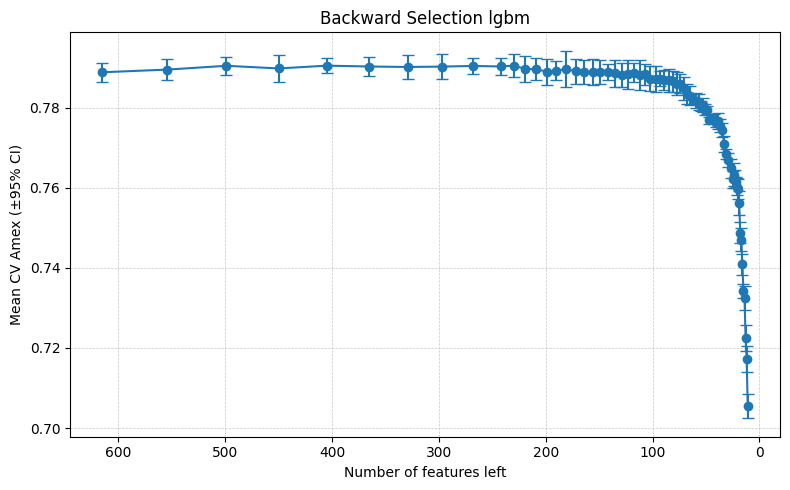

In [ ]:
# plot backward selection without test scores
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
test_scores_kaggle = []

In [47]:
raw = """
submission_lgbm_test_backward_11_feats.csv
Complete (after deadline) · 1m ago
0.72101

0.70990

submission_lgbm_test_backward_12_feats.csv
Complete (after deadline) · 2m ago
0.73459

0.72024

submission_lgbm_test_backward_13_feats.csv
Complete (after deadline) · 2m ago
0.73960

0.72584

submission_lgbm_test_backward_14_feats.csv
Complete (after deadline) · 2m ago
0.74818

0.73514

submission_lgbm_test_backward_15_feats.csv
Complete (after deadline) · 2m ago
0.74967

0.73707

submission_lgbm_test_backward_16_feats.csv
Complete (after deadline) · 2m ago
0.75225

0.74167

submission_lgbm_test_backward_17_feats.csv
Complete (after deadline) · 3m ago
0.75908

0.74677

submission_lgbm_test_backward_18_feats.csv
Complete (after deadline) · 3m ago
0.76083

0.74733

submission_lgbm_test_backward_19_feats.csv
Complete (after deadline) · 3m ago
0.76693

0.75445

submission_lgbm_test_backward_20_feats.csv
Complete (after deadline) · 18m ago
0.77198

0.75926

submission_lgbm_test_backward_21_feats.csv
Complete (after deadline) · 18m ago
0.77235

0.75995

submission_lgbm_test_backward_22_feats.csv
Complete (after deadline) · 18m ago
0.77325

0.76130

submission_lgbm_test_backward_23_feats.csv
Complete (after deadline) · 19m ago
0.77462

0.76238

submission_lgbm_test_backward_24_feats.csv
Complete (after deadline) · 19m ago
0.77481

0.76283

submission_lgbm_test_backward_25_feats.csv
Complete (after deadline) · 19m ago
0.77389

0.76193

submission_lgbm_test_backward_27_feats.csv
Complete (after deadline) · 19m ago
0.77663

0.76478

submission_lgbm_test_backward_29_feats.csv
Complete (after deadline) · 19m ago
0.77852

0.76610

submission_lgbm_test_backward_31_feats.csv
Complete (after deadline) · 20m ago
0.78009

0.76781

submission_lgbm_test_backward_33_feats.csv
Complete (after deadline) · 20m ago
0.78092

0.76960

submission_lgbm_test_backward_35_feats.csv
Complete (after deadline) · 20m ago
0.78604

0.77477

submission_lgbm_test_backward_37_feats.csv
Complete (after deadline) · 20m ago
0.78688

0.77585

submission_lgbm_test_backward_39_feats.csv
Complete (after deadline) · 21m ago
0.78733

0.77610

submission_lgbm_test_backward_41_feats.csv
Complete (after deadline) · 21m ago
0.78779

0.77677

submission_lgbm_test_backward_43_feats.csv
Complete (after deadline) · 21m ago
0.78895

0.77760

submission_lgbm_test_backward_45_feats.csv
Complete (after deadline) · 21m ago
0.78898

0.77778

submission_lgbm_test_backward_47_feats.csv
Complete (after deadline) · 21m ago
0.78908

0.77739

submission_lgbm_test_backward_49_feats.csv
Complete (after deadline) · 22m ago
0.78963

0.77958

submission_lgbm_test_backward_51_feats.csv
Complete (after deadline) · 22m ago
0.79089

0.78057

submission_lgbm_test_backward_53_feats.csv
Complete (after deadline) · 22m ago
0.79116

0.78081

submission_lgbm_test_backward_55_feats.csv
Complete (after deadline) · 22m ago
0.79153

0.78112

submission_lgbm_test_backward_57_feats.csv
Complete (after deadline) · 23m ago
0.79203

0.78163

submission_lgbm_test_backward_59_feats.csv
Complete (after deadline) · 23m ago
0.79243

0.78160

submission_lgbm_test_backward_62_feats.csv
Complete (after deadline) · 23m ago
0.79249

0.78251

submission_lgbm_test_backward_65_feats.csv
Complete (after deadline) · 23m ago
0.79374

0.78344

submission_lgbm_test_backward_68_feats.csv
Complete (after deadline) · 23m ago
0.79490

0.78472

submission_lgbm_test_backward_71_feats.csv
Complete (after deadline) · 24m ago
0.79521

0.78534

submission_lgbm_test_backward_74_feats.csv
Complete (after deadline) · 24m ago
0.79610

0.78638

submission_lgbm_test_backward_77_feats.csv
Complete (after deadline) · 24m ago
0.79604

0.78680

submission_lgbm_test_backward_81_feats.csv
Complete (after deadline) · 24m ago
0.79619

0.78691

submission_lgbm_test_backward_85_feats.csv
Complete (after deadline) · 25m ago
0.79689

0.78655

submission_lgbm_test_backward_89_feats.csv
Complete (after deadline) · 25m ago
0.79739

0.78722

submission_lgbm_test_backward_93_feats.csv
Complete (after deadline) · 25m ago
0.79681

0.78683

submission_lgbm_test_backward_97_feats.csv
Complete (after deadline) · 26m ago
0.79663

0.78682

submission_lgbm_test_backward_102_feats.csv
Complete (after deadline) · 26m ago
0.79701

0.78695

submission_lgbm_test_backward_107_feats.csv
Complete (after deadline) · 26m ago
0.79877

0.78827

submission_lgbm_test_backward_112_feats.csv
Complete (after deadline) · 26m ago
0.79893

0.78848

submission_lgbm_test_backward_117_feats.csv
Complete (after deadline) · 26m ago
0.79933

0.78861

submission_lgbm_test_backward_123_feats.csv
Complete (after deadline) · 27m ago
0.79934

0.78885

submission_lgbm_test_backward_129_feats.csv
Complete (after deadline) · 27m ago
0.79859

0.78914

submission_lgbm_test_backward_135_feats.csv
Complete (after deadline) · 27m ago
0.79888

0.78943

submission_lgbm_test_backward_142_feats.csv
Complete (after deadline) · 28m ago
0.79951

0.79020

submission_lgbm_test_backward_149_feats.csv
Complete (after deadline) · 28m ago
0.79951

0.78973

submission_lgbm_test_backward_156_feats.csv
Complete (after deadline) · 28m ago
0.79916

0.78982

submission_lgbm_test_backward_164_feats.csv
Complete (after deadline) · 28m ago
0.79975

0.79026

submission_lgbm_test_backward_172_feats.csv
Complete (after deadline) · 29m ago
0.79943

0.79011

submission_lgbm_test_backward_181_feats.csv
Complete (after deadline) · 29m ago
0.79962

0.79006

submission_lgbm_test_backward_190_feats.csv
Complete (after deadline) · 29m ago
0.79956

0.79045

submission_lgbm_test_backward_199_feats.csv
Complete (after deadline) · 29m ago
0.79967

0.79006

submission_lgbm_test_backward_209_feats.csv
Complete (after deadline) · 30m ago
0.79970

0.79014

submission_lgbm_test_backward_219_feats.csv
Complete (after deadline) · 30m ago
0.80115

0.79099

submission_lgbm_test_backward_230_feats.csv
Complete (after deadline) · 30m ago
0.80025

0.79098

submission_lgbm_test_backward_242_feats.csv
Complete (after deadline) · 30m ago
0.80091

0.79124

submission_lgbm_test_backward_268_feats.csv
Complete (after deadline) · 30m ago
0.80137

0.79150

submission_lgbm_test_backward_297_feats.csv
Complete (after deadline) · 31m ago
0.80108

0.79115

submission_lgbm_test_backward_329_feats.csv
Complete (after deadline) · 31m ago
0.80094

0.79150

submission_lgbm_test_backward_365_feats.csv
Complete (after deadline) · 31m ago
0.80098

0.79183

submission_lgbm_test_backward_405_feats.csv
Complete (after deadline) · 31m ago
0.80123

0.79159

submission_lgbm_test_backward_450_feats.csv
Complete (after deadline) · 32m ago
0.80092

0.79198

submission_lgbm_test_backward_499_feats.csv
Complete (after deadline) · 32m ago
0.80092

0.79189

submission_lgbm_test_backward_554_feats.csv
Complete (after deadline) · 32m ago
0.80073

0.79086

submission_lgbm_test_backward_615_feats.csv
Complete (after deadline) · 33m ago
0.80066

0.79120
"""

In [48]:
# --- парсим ---------------------------------------------------------------
lines = [ln.strip() for ln in raw.strip().splitlines() if ln.strip()]

private_scores, public_scores = [], []

# обходим блоки по 4 строки снизу вверх
# 0: имя файла, 1: статус/время, 2: private, 3: public
for i in range(len(lines)-1, -1, -4):
    public  = float(lines[i])       # последняя строка блока
    private = float(lines[i-1])     # предпоследняя
    public_scores.append(public)
    private_scores.append(private)

# теперь списки идут от 615‑feats -> … -> 11‑feats
print("Private:", private_scores[:5], "...", private_scores[-5:])
print("Public :", public_scores [:5], "...", public_scores [-5:])

Private: [0.80066, 0.80073, 0.80092, 0.80092, 0.80123] ... [0.74967, 0.74818, 0.7396, 0.73459, 0.72101]
Public : [0.7912, 0.79086, 0.79189, 0.79198, 0.79159] ... [0.73707, 0.73514, 0.72584, 0.72024, 0.7099]


In [50]:
len(private_scores), len(public_scores)

(71, 71)

In [97]:
import pickle

# list_imp_dfs  – ваш список словарей {'step': k, 'importance': df}

file_path = "list_imp_dfs_after_backward.pkl"

with open(file_path, "wb") as f:
    pickle.dump(list_imp_dfs, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved to {file_path}")

Saved to list_imp_dfs_after_backward.pkl


In [99]:
with open("list_imp_dfs_after_backward.pkl", "rb") as f:
    test_file_abc = pickle.load(f)

In [101]:
len(test_file_abc)

71

In [105]:
len(test_file_abc[34]['importance'])

74

In [ ]:
# log_df["test"] = private_scores

In [ ]:
log_df[["n_feats_left", "cv_mean", "test"]]

,n_feats_left,cv_mean,test
0,615,0.788812,0.80066
1,554,0.789482,0.80073
2,499,0.790431,0.80092
3,450,0.789769,0.80092
4,405,0.790460,0.80123
5,365,0.790252,0.80098
6,329,0.790131,0.80094
7,297,0.790228,0.80108
8,268,0.790394,0.80137
9,242,0.790253,0.80091


In [106]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi,test
0,0,615,545,9,6,400,0.788812,0.786443,0.791182,0.80066
1,1,554,492,7,6,400,0.789482,0.786798,0.792166,0.80073
2,2,499,443,7,6,471,0.790431,0.788130,0.792732,0.80092
3,3,450,398,7,6,471,0.789769,0.786424,0.793115,0.80092
4,4,405,359,6,6,471,0.790460,0.788618,0.792302,0.80123
5,5,365,323,6,6,471,0.790252,0.787776,0.792728,0.80098
6,6,329,291,6,6,471,0.790131,0.787070,0.793193,0.80094
7,7,297,262,6,6,481,0.790228,0.787106,0.793350,0.80108
8,8,268,237,5,6,481,0.790394,0.788437,0.792351,0.80137
9,9,242,225,5,6,481,0.790253,0.788196,0.792310,0.80091


In [ ]:
# log_df.to_csv("logging_w_test_score_backward_selection.csv", index=False)

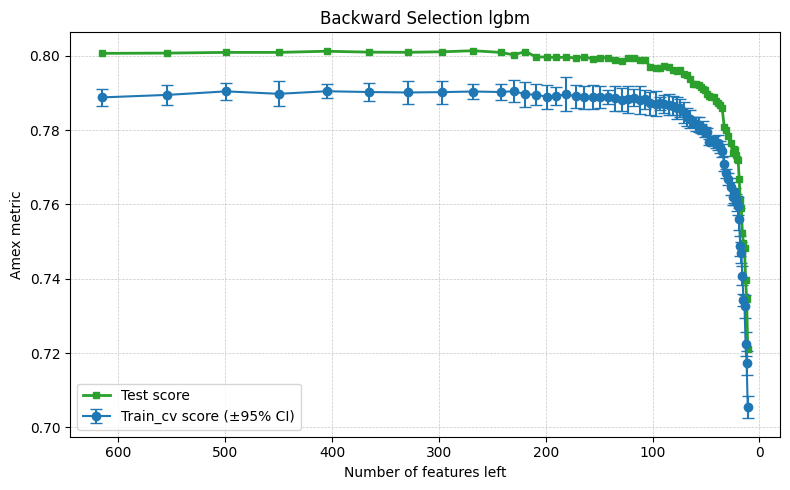

In [ ]:
# plot backward selection without test scores
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4, label="Train_cv score (±95% CI)")

# линия Private
plt.plot(x, private_scores, '-s', color='tab:green',
        label='Test score', linewidth=2, markersize=5)

plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Amex metric")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.legend()
plt.show()

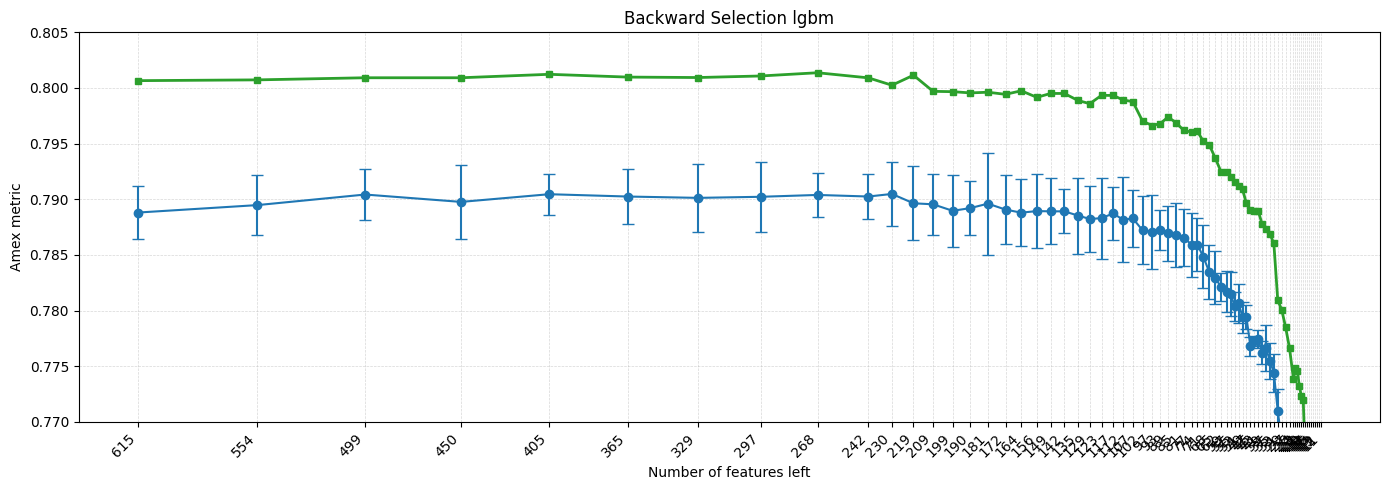

In [80]:
import matplotlib.pyplot as plt

plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                    .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# --- фигура и оси --------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 5))

ax.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)

# линия Private LB
ax.plot(x, private_scores, '-s', color='tab:green',
        label='Test score', linewidth=2, markersize=5)

ax.invert_xaxis()                                # много → мало фичей
plt.xlabel("Number of features left")
plt.ylabel("Amex metric")
plt.title("Backward Selection lgbm")

# xticks для каждой итерации
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45, ha='right')

# --- желаемые пределы Y -------------------------------------------
ax.set(ylim=[0.77, 0.805])

ax.grid(alpha=0.5, linestyle='--', linewidth=0.5)
fig.tight_layout()
plt.show()

In [92]:
list_imp_dfs[34]["importance"].shape

(74, 3)

In [93]:
list_imp_dfs[34]["importance"]

,feature,gain,share
3,P_2_last,1.740261e+06,0.556823
48,B_1_last,1.922792e+05,0.061523
1,P_2_avg,1.599758e+05,0.051187
49,B_2_last,9.622262e+04,0.030788
54,B_9_last,6.180064e+04,0.019774
0,P_2_min,5.539204e+04,0.017724
23,D_39_last,4.967316e+04,0.015894
68,R_2_last,4.715547e+04,0.015088
35,S_3_avg,3.694942e+04,0.011823
26,D_44_last,3.455267e+04,0.011056


In [ ]:
# === Step 34 | feats 74 (num 73, cat 1) | depth 7 trees 484

In [108]:
with open("list_imp_dfs_after_backward.pkl", "rb") as f:
    test_file_abc = pickle.load(f)

In [110]:
test_file_abc[-1]

{'step': 70,
 'importance':       feature          gain     share
 1    P_2_last  1.561377e+06  0.607496
 0     P_2_avg  5.429265e+05  0.211240
 5    B_1_last  2.940387e+05  0.114404
 6    B_2_last  1.718444e+05  0.066861
 2    D_87_min  0.000000e+00  0.000000
 4    B_31_max  0.000000e+00  0.000000
 3   D_108_min  0.000000e+00  0.000000
 7    R_18_min  0.000000e+00  0.000000
 8    R_22_min  0.000000e+00  0.000000
 9    R_23_min  0.000000e+00  0.000000
 10   R_25_min  0.000000e+00  0.000000}

In [120]:
test_file_abc[34]["importance"].shape

(74, 3)

In [121]:
test_file_abc[34]["importance"].query("gain > 0").shape

(59, 3)

In [122]:
test_file_abc[34]["importance"].query("gain > 0")

,feature,gain,share
3,P_2_last,1.740261e+06,0.556823
48,B_1_last,1.922792e+05,0.061523
1,P_2_avg,1.599758e+05,0.051187
49,B_2_last,9.622262e+04,0.030788
54,B_9_last,6.180064e+04,0.019774
0,P_2_min,5.539204e+04,0.017724
23,D_39_last,4.967316e+04,0.015894
68,R_2_last,4.715547e+04,0.015088
35,S_3_avg,3.694942e+04,0.011823
26,D_44_last,3.455267e+04,0.011056


### Permutation importance

In [4]:
with open("list_imp_dfs_after_backward.pkl", "rb") as f:
    df_w_importances = pickle.load(f)

In [5]:
num_features = [feat for feat in df_w_importances[34]["importance"].feature.to_list() if feat != "B_38_last"]
cat_features = ["B_38_last"]

len(num_features) + len(cat_features)

74

In [11]:
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from scipy import stats
import pandas as pd
import numpy as np

def run_permutation_selection(df_train,
                               df_test,
                               target_col,
                               num_feats,
                               cat_feats,
                               group_col,
                               min_feats: int = 10,
                               random_state: int = 42):

    num, cat = num_feats.copy(), cat_feats.copy()
    y, groups = df_train[target_col].values, df_train[group_col].values
    sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)
    test_preds_df = pd.DataFrame(index=df_test.customer_ID)

    history, list_imp_dfs, step = [], [], 0

    params = dict(
        learning_rate=.05, subsample=.9, subsample_freq=1,
        colsample_bytree=.8, objective='binary',
        random_state=random_state,
        max_depth=7, n_estimators=484,
        n_jobs=-1, verbosity=-1
    )

    while True:
        feats = num + cat
        if len(feats) <= min_feats:
            break

        print(f"\n=== Step {step} | feats {len(feats)} "
                f"(num {len(num)}, cat {len(cat)})")

        # -------- CV and logging ------------------------------------
        fold_scores, fold_test_raw = [], []
        fold_importances = []
        for fold, (tr_idx, va_idx) in enumerate(sgkf.split(df_train[[group_col, target_col]], y, groups)):
            print(f" Fold {fold}")
            X_tr, X_va = df_train.iloc[tr_idx][feats], df_train.iloc[va_idx][feats]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr, categorical_feature=cat)

            pred = model.predict_proba(X_va)[:, 1]
            score = get_amex_metric_calculated(y_va, pred)
            print(f" Amex = {score:.5f}")
            fold_scores.append(score)
            fold_test_raw.append(model.predict_proba(df_test[feats], raw_score=True))
            
            print("running permutation importance")
            result = permutation_importance(
                model, X_va, y_va,
                n_repeats=2, # 5
                random_state=random_state,
                scoring=lambda est, X, y: get_amex_metric_calculated(y, est.predict_proba(X)[:, 1]),
                n_jobs=-1
            )
            fold_importances.append(pd.Series(result.importances_mean, index=feats))

        # Mean score + CI
        mean_cv = np.mean(fold_scores)
        ci = stats.t.interval(0.95, len(fold_scores)-1, loc=mean_cv, scale=stats.sem(fold_scores))
        print(f"Mean CV Amex = {mean_cv:.5f}  CI95 = [{ci[0]:.5f}, {ci[1]:.5f}]")
        test_preds_df[f'iter_{step}'] = np.mean(fold_test_raw, axis=0)

        # Aggregate and save importance
        mean_importance = pd.concat(fold_importances, axis=1).mean(axis=1)
        imp_df = (mean_importance
                  .rename("importance")
                  .reset_index()
                  .rename(columns={"index": "feature"})
                  .sort_values("importance", ascending=False)
                  .reset_index(drop=True))
        list_imp_dfs.append({"step": step, "importance": imp_df}) # <------------------------------ хуета

        # Drop the least important
        worst_feat = imp_df.iloc[-1]["feature"]
        print(f" Dropping: {worst_feat} | Importance: {imp_df.iloc[-1]['importance']:.5f}")

        # Drop from lists
        num = [f for f in num if f != worst_feat]
        cat = [f for f in cat if f != worst_feat]

        history.append({
            'step': step,
            'n_feats_left': len(feats),
            'dropped_feat': worst_feat,
            'cv_mean': mean_cv,
            'cv_ci_lo': ci[0],
            'cv_ci_hi': ci[1],
        })

        step += 1

    return pd.DataFrame(history), list_imp_dfs, test_preds_df


In [12]:
hist, perm_imp_dfs, test_preds_df = run_permutation_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=72
)


=== Step 0 | feats 74 (num 73, cat 1)
 Fold 0
 Amex = 0.78407
running permutation importance
 Fold 1
 Amex = 0.78657
running permutation importance
 Fold 2
 Amex = 0.78481
running permutation importance
 Fold 3
 Amex = 0.78629
running permutation importance
 Fold 4
 Amex = 0.78748
running permutation importance
Mean CV Amex = 0.78584  CI95 = [0.78413, 0.78756]
 Dropping: R_18_last | Importance: -0.00000

=== Step 1 | feats 73 (num 72, cat 1)
 Fold 0
 Amex = 0.78375
running permutation importance
 Fold 1
 Amex = 0.78677
running permutation importance
 Fold 2
 Amex = 0.78662
running permutation importance
 Fold 3
 Amex = 0.78555
running permutation importance
 Fold 4
 Amex = 0.78983
running permutation importance
Mean CV Amex = 0.78651  CI95 = [0.78376, 0.78926]
 Dropping: R_10_min | Importance: -0.00001


In [13]:
perm_imp_dfs

[{'step': 0,
  'importance':       feature    importance
  0    P_2_last  5.776854e-02
  1    B_1_last  1.668614e-02
  2   D_39_last  6.962491e-03
  3    B_4_last  5.667216e-03
  4    B_3_last  5.261204e-03
  ..        ...           ...
  69   B_31_max  0.000000e+00
  70   R_18_min  0.000000e+00
  71   R_22_min  0.000000e+00
  72   R_23_min  0.000000e+00
  73  R_18_last -5.842390e-07
  
  [74 rows x 2 columns]},
 {'step': 1,
  'importance':       feature    importance
  0    P_2_last  5.547867e-02
  1    B_1_last  1.653730e-02
  2   D_39_last  6.850132e-03
  3    B_3_last  5.270397e-03
  4    B_28_min  5.240590e-03
  ..        ...           ...
  68   R_23_min  0.000000e+00
  69   R_15_min  0.000000e+00
  70   R_22_min  0.000000e+00
  71  R_28_last -3.014991e-09
  72   R_10_min -1.070495e-05
  
  [73 rows x 2 columns]}]

In [14]:
test_preds_df

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.108845,-3.015539
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.709155,-6.837671
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.516959,-2.500298
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.956219,-0.954559
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,1.839630,1.852987
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.627349,-3.650280
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.360705,1.326492
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.260396,0.271246


In [15]:
hist

,step,n_feats_left,dropped_feat,cv_mean,cv_ci_lo,cv_ci_hi
0,0,74,R_18_last,0.785845,0.784134,0.787555
1,1,73,R_10_min,0.786506,0.783755,0.789256


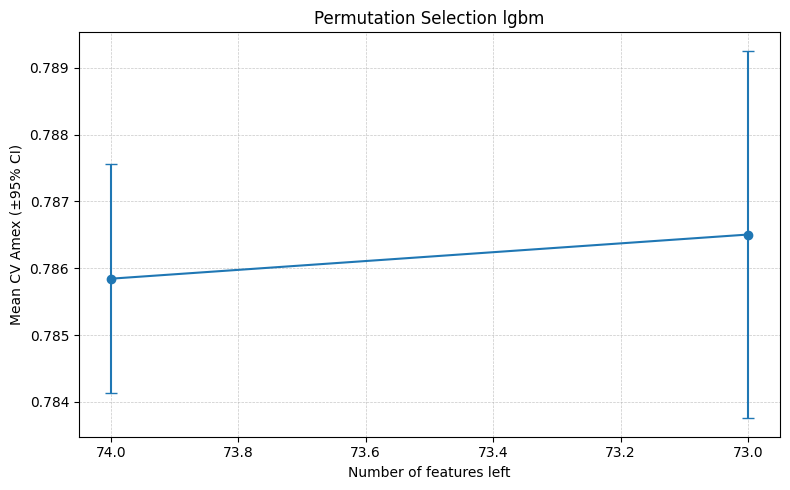

In [16]:
# plot backward selection without test scores
plot_df = (hist.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Permutation Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
hist, perm_imp_dfs, test_preds_df = run_permutation_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=10
)


=== Step 0 | feats 74 (num 73, cat 1)
 Fold 0
 Amex = 0.78407
running permutation importance
 Fold 1
 Amex = 0.78657
running permutation importance
 Fold 2
 Amex = 0.78481
running permutation importance
 Fold 3
 Amex = 0.78629
running permutation importance
 Fold 4
 Amex = 0.78748
running permutation importance
Mean CV Amex = 0.78584  CI95 = [0.78413, 0.78756]


NameError: name 'list_imp_dfs' is not defined

In [22]:
perm_imp_dfs

[{'step': 0,
  'importance':        feature          gain     share
  9     P_2_last  1.533642e+06  0.486181
  6      P_2_avg  2.646546e+05  0.083898
  465   B_1_last  2.199363e+05  0.069722
  0      P_2_min  1.404754e+05  0.044532
  466   B_2_last  7.859373e+04  0.024915
  ..         ...           ...       ...
  53    D_96_min  0.000000e+00  0.000000
  58   D_107_min  0.000000e+00  0.000000
  59   D_108_min  0.000000e+00  0.000000
  60   D_109_min  0.000000e+00  0.000000
  61   D_111_min  0.000000e+00  0.000000
  
  [615 rows x 3 columns]},
 {'step': 1,
  'importance':       feature          gain     share
  9    P_2_last  1.510407e+06  0.478716
  424  B_1_last  2.055820e+05  0.065158
  0     P_2_min  1.601022e+05  0.050744
  6     P_2_avg  1.402108e+05  0.044439
  3     P_2_max  1.195222e+05  0.037882
  ..        ...           ...       ...
  503   R_4_avg  0.000000e+00  0.000000
  516  R_18_avg  0.000000e+00  0.000000
  515  R_17_avg  0.000000e+00  0.000000
  512  R_13_avg  0.00000

In [23]:
test_preds_df

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.108845,-3.015539
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.709155,-6.837671
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.516959,-2.500298
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.956219,-0.954559
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,1.839630,1.852987
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.627349,-3.650280
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.360705,1.326492
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.260396,0.271246


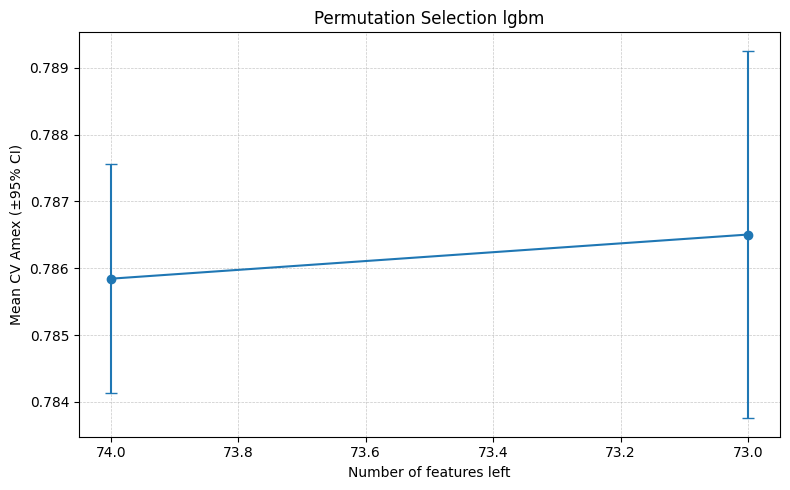

In [25]:
# plot backward selection without test scores
plot_df = (hist.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Permutation Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()